In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import kerastuner as kt
from sklearn.model_selection import train_test_split

In [ ]:
#input with all maxima
df_spectra_all=pd.read_csv("spectrum_energy_input_numberOfPeaks.csv",index_col=[0])
x_data_string=df_spectra_all["all_maxima"].values

max_nr_of_max=df_spectra_all['no_of_max'].max()
len_array=len(df_spectra_all["all_maxima"].values)

print(max_nr_of_max,len_array)
x_data_padded=np.zeros((len_array,max_nr_of_max))

for i,x_string in enumerate(x_data_string):
    x_string=x_string.replace('\n','').replace('[','').replace(']','')
    x_split= x_string.split(' ')
    j=0
    for x in (x_split):
        if(x!=''):
            #print(x)
            x_data_padded[i,j]=float(x)
            j=j+1
    #print("cut")

y_data=df_spectra_all[["k6a1","k6a2","k11","k12","k9a1","k9a2"]].to_numpy()


y_data=y_data-0.5
y_data=y_data*4


data_train, data_test, labels_train, labels_test = train_test_split(x_data_padded, y_data, test_size=0.20, random_state=42)
   
print(data_train.shape)

def transform_data(df,index):
    data=df[index].to_numpy()
    new_data=np.zeros((len(data),max(data)+1))    
    for i in range(len(data)):
        new_data[i,data[i]]=1
    return new_data
    
df_spectra=pd.read_csv("spectrum_energy_input_numberOfPeaks.csv",index_col=[0])
df_new=df_spectra.loc[df_spectra["k11"] == 0]


x_data=transform_data(df_new,"no_of_max")
print(x_data[0:2])



y_data=df_spectra[["k6a1","k6a2","k11","k12","k9a1","k9a2"]].to_numpy()


y_data=y_data-0.5
y_data=y_data*4
print(y_data[0:10])


data_train, data_test, labels_train, labels_test = train_test_split(x_data, y_data, test_size=0.20, random_state=42)

print(data_train.shape)
print(labels_train.shape)

#df_training = df_spectra.sample(frac=0.8,random_state=10)
#df_testing=df_spectra.drop(df_training.index)
#df_spectra.head()

In [ ]:
feature_columns_A = []

no_of_max = tf.feature_column.numeric_column("all_maxima")
my_feature_layer_A = tf.keras.layers.DenseFeatures(no_of_max)

#transform data


In [ ]:

def plot_the_loss_curve(epochs, mse,val_mse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Loss")
    plt.plot(epochs, val_mse, label="Val Loss")

    plt.legend()
    #plt.ylim([0, 15])
    plt.show()  

def create_model(my_learning_rate, my_feature_layer):
    model = tf.keras.models.Sequential()
    # Add the layer containing the feature columns to the model.
    # Define the first hidden layer with 10 nodes.   
   # model.add(my_feature_layer_A)
    #layers=[5,10]
    layers=[600,600,600,600]
    for layer in layers:
        model.add(tf.keras.layers.Dense(units = layer, activation = 'sigmoid',kernel_regularizer=tf.keras.regularizers.l1(0.0)))
    # Define the output layer.
    model.add(tf.keras.layers.Dense(units=6,  
                                    name='Output',activation="sigmoid"))#,kernel_regularizer=tf.keras.regularizers.l2(0.04)))                              
  
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=my_learning_rate,momentum=0.1),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

    return model



def train_model(model, x,y, epochs, label_name,
                batch_size=None):

    #features = {name:np.array(value) for name, value in dataset.items()}
    #label=dataset[label_name].to_numpy()
    history = model.fit(x=x, y=y, batch_size=batch_size,
                      epochs=epochs, shuffle=True, verbose=1,validation_split=0.2) 
    
    epochs = history.epoch
  
    df_hist = pd.DataFrame(history.history)
    #hist.head()
    #mse = hist["mean_squared_error"]
    mae = df_hist["mean_squared_error"].to_numpy()
    val_mae = df_hist["val_mean_squared_error"].to_numpy()
    return epochs,mae,val_mae

In [ ]:
# The following variables are the hyperparameters.
#data_train, data_test, labels_train, labels_test
learning_rate = 1e-1
epochs = 500
batch_size = 400

label_name = ["k6a1","k6a2","k11","k12","k9a1","k9a2"]

my_model = create_model(learning_rate, my_feature_layer_A)

epochs, mse,val_mse = train_model(my_model, data_train,labels_train, epochs, 
                          label_name, batch_size)


In [ ]:
#features = {name:np.array(value) for name, value in df_test.items()}
#label=df_test[label_name].to_numpy()
#data_train, data_test, labels_train, labels_test
plot_the_loss_curve(epochs, mse,val_mse)
evaluation=my_model.evaluate(x = data_test, y = labels_test, batch_size=batch_size)
predicted = my_model.predict(data_test)
print(evaluation)



df_test=pd.DataFrame(labels_test,columns=["k6a1_test","k6a2_test","k11_test","k12_test","k9a1_test","k9a2_test"])
df_predict=pd.DataFrame(predicted,columns=["k6a1_hat","k6a2_hat","k11_hat","k12_hat","k9a1_hat","k9a2_hat"])
pd.concat([df_test,df_predict], axis=1).head()

In [ ]:
print(data_test[0:5])
print(labels_test[0:5])


In [118]:
#new try with 2d Data:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import kerastuner as kt
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

def get_array_from_strings(data_string, padded_array):
    use_paddad_array=padded_array.copy()
    for i,x_string in enumerate(data_string):
        x_string=x_string.replace('\n','').replace('[','').replace(']','')
        x_split= x_string.split(' ')
        j=0
        for x in (x_split):
            if(x!=''):
                #print(x)
                use_paddad_array[i,j]=float(x)
                j=j+1

    return use_paddad_array

In [280]:
#input with all maxima
df_spectra_all=pd.read_csv("spectrum_energy_input_numberOfPeaks_with_intensity.csv",index_col=[0])
x_Energy_string=df_spectra_all["all_maxima"].values
x_Intensity_string=df_spectra_all["Intensity"].values



max_nr_of_max=df_spectra_all['no_of_max'].max()
len_array=len(df_spectra_all["all_maxima"].values)

#print(max_nr_of_max,len_array)
x_data_padded=np.zeros((len_array,max_nr_of_max))


x_energy_padded=get_array_from_strings(x_Energy_string,x_data_padded)
x_Intensity_padded=get_array_from_strings(x_Intensity_string,x_data_padded)

#print(x_data_padded[:5])    
#print(x_energy_padded[:5])    
#print(x_Intensity_padded[:5])    

#make 2d Array from Energy and Intensity
x_data_2d =np.zeros((len(x_energy_padded),len(x_energy_padded[0]),2))
for i in range(len(x_energy_padded)):
    for j in range(len(x_energy_padded[i])):
        x_data_2d[i,j,0]=x_energy_padded[i,j]
        x_data_2d[i,j,1]=x_Intensity_padded[i,j]

#print(x_data_2d[:5]) 

#convert y_data into 2d array where -1=[1,0] 0=[0,0] 1=[0,1]
y_data=df_spectra_all[["k6a1","k6a2","k11","k12","k9a1","k9a2"]].to_numpy()
y_data=y_data-0.5
y_data=y_data*4
#y_data=y_data+2
y_data_2d =np.zeros((len(y_data),len(y_data[0]),2))
#print(y_data_2d.shape)
for i in range(len(y_data)):
    for j in range(len(y_data[i])):
        if(y_data[i,j]==-1):
            y_data_2d[i,j,0]=1
        elif(y_data[i,j]==1):
            y_data_2d[i,j,1]=1
            
#print(y_data[:5])
#print(y_data_2d[:5])


#y_data_cat=to_categorical(y_data)
#print(y_data_cat.shape)
y_data_2d=y_data_2d.reshape(y_data_2d.shape[0],y_data_2d.shape[2]*y_data_2d.shape[1])
#print(y_data_cat.shape)

#this is with 1d label
data_train, data_test, labels_train, labels_test = train_test_split(x_data_2d, y_data, test_size=0.20, random_state=43)
#this is with 2d label
#data_train, data_test, labels_train, labels_test = train_test_split(x_data_2d, y_data_2d, test_size=0.20, random_state=42)



#maybe reshape data into [nr,x,y,channel=1?]   
print(data_train.shape)
print(labels_train.shape)

(583, 22, 2)
(583, 6)


In [336]:

def plot_the_loss_curve(epochs, mse,val_mse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Loss")
    plt.plot(epochs, val_mse, label="Val Loss")

    plt.legend()
    #plt.ylim([0, 15])
    plt.show()  

def create_2d_model(my_learning_rate, input_shape):
    model = tf.keras.models.Sequential()
    # Add the layer containing the feature columns to the model.
    # Define the first hidden layer with 10 nodes.   
    
    model.add(tf.keras.layers.Conv1D(64, 2, activation='relu',input_shape=input_shape))
    #model.add(tf.keras.layers.Conv1D(128, 4, activation='linear'))
   # model.add(tf.keras.layers.MaxPooling1D(2,2))

   #print model.add(tf.keras.layers.Conv1D(256, 4, activation='exponential'))
    #model.add(tf.keras.layers.MaxPooling1D(128))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units = 128, activation = 'softmax',kernel_regularizer=tf.keras.regularizers.l1(0)))
   # model.add(tf.keras.layers.Dropout(0.5))
   # model.add(tf.keras.layers.Dense(units = 6, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l1(0)))

    model.add(tf.keras.layers.Dense(units = 6, activation = 'softmax',kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    #model.add(tf.keras.layers.Flatten())

    
    
    
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=my_learning_rate,momentum=0.1),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

    return model



def train_model(model, x,y, epochs,
                batch_size=None):

    #features = {name:np.array(value) for name, value in dataset.items()}
    #label=dataset[label_name].to_numpy()
    history = model.fit(x=x, y=y, batch_size=batch_size,
                      epochs=epochs, shuffle=True, verbose=1,validation_split=0.1) 
    
    epochs = history.epoch
  
    df_hist = pd.DataFrame(history.history)
    #hist.head()
    #mse = hist["mean_squared_error"]
    mae = df_hist["mean_squared_error"].to_numpy()
    val_mae = df_hist["val_mean_squared_error"].to_numpy()
    return epochs,mae,val_mae

In [337]:
#data_train,data_test,labels_train,labels_test
input_shape=(data_train.shape[1:3])
print(input_shape)



(22, 2)


In [338]:
two_d_model=create_2d_model(0.01,(22,2))
print(labels_train[:5])

[[ 0. -1.  1.  1.  1.  0.]
 [ 0.  1.  1. -1.  0.  1.]
 [-1.  0.  1. -1.  1.  0.]
 [ 0.  0. -1. -1.  1. -1.]
 [ 1.  0.  1.  0.  0.  0.]]


In [339]:
two_d_model.summary()


Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_164 (Conv1D)          (None, 21, 64)            320       
_________________________________________________________________
flatten_46 (Flatten)         (None, 1344)              0         
_________________________________________________________________
dense_121 (Dense)            (None, 128)               172160    
_________________________________________________________________
dense_122 (Dense)            (None, 6)                 774       
Total params: 173,254
Trainable params: 173,254
Non-trainable params: 0
_________________________________________________________________


In [340]:
epochs, mse,val_mse =train_model(two_d_model,data_train,labels_train,200)

Epoch 1/200
17/17 [==============================] - ETA: 0s - loss: 1.5630 - mean_squared_error: 0.73 - 0s 5ms/step - loss: 1.5159 - mean_squared_error: 0.6959 - val_loss: 1.5310 - val_mean_squared_error: 0.7190
Epoch 2/200
17/17 [==============================] - ETA: 0s - loss: 1.5238 - mean_squared_error: 0.71 - 0s 2ms/step - loss: 1.5015 - mean_squared_error: 0.6959 - val_loss: 1.5167 - val_mean_squared_error: 0.7190
Epoch 3/200
17/17 [==============================] - ETA: 0s - loss: 1.5128 - mean_squared_error: 0.71 - 0s 2ms/step - loss: 1.4873 - mean_squared_error: 0.6959 - val_loss: 1.5026 - val_mean_squared_error: 0.7190
Epoch 4/200
17/17 [==============================] - ETA: 0s - loss: 1.5408 - mean_squared_error: 0.75 - 0s 2ms/step - loss: 1.4732 - mean_squared_error: 0.6959 - val_loss: 1.4885 - val_mean_squared_error: 0.7190
Epoch 5/200
17/17 [==============================] - ETA: 0s - loss: 1.4985 - mean_squared_error: 0.72 - 0s 2ms/step - loss: 1.4591 - mean_squared_e

17/17 [==============================] - ETA: 0s - loss: 1.0132 - mean_squared_error: 0.64 - 0s 2ms/step - loss: 1.0549 - mean_squared_error: 0.6958 - val_loss: 1.0731 - val_mean_squared_error: 0.7194
Epoch 40/200
17/17 [==============================] - ETA: 0s - loss: 1.0479 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 1.0452 - mean_squared_error: 0.6958 - val_loss: 1.0636 - val_mean_squared_error: 0.7194
Epoch 41/200
17/17 [==============================] - ETA: 0s - loss: 1.0073 - mean_squared_error: 0.66 - 0s 2ms/step - loss: 1.0358 - mean_squared_error: 0.6958 - val_loss: 1.0542 - val_mean_squared_error: 0.7194
Epoch 42/200
17/17 [==============================] - ETA: 0s - loss: 1.0398 - mean_squared_error: 0.70 - 0s 2ms/step - loss: 1.0265 - mean_squared_error: 0.6958 - val_loss: 1.0449 - val_mean_squared_error: 0.7194
Epoch 43/200
17/17 [==============================] - ETA: 0s - loss: 1.0025 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 1.0173 - mean_squared_error: 0.

17/17 [==============================] - ETA: 0s - loss: 0.7170 - mean_squared_error: 0.62 - 0s 2ms/step - loss: 0.7821 - mean_squared_error: 0.6958 - val_loss: 0.8030 - val_mean_squared_error: 0.7192
Epoch 78/200
17/17 [==============================] - ETA: 0s - loss: 0.7601 - mean_squared_error: 0.67 - 0s 2ms/step - loss: 0.7776 - mean_squared_error: 0.6958 - val_loss: 0.7986 - val_mean_squared_error: 0.7192
Epoch 79/200
17/17 [==============================] - ETA: 0s - loss: 0.7144 - mean_squared_error: 0.63 - 0s 2ms/step - loss: 0.7731 - mean_squared_error: 0.6958 - val_loss: 0.7942 - val_mean_squared_error: 0.7192
Epoch 80/200
17/17 [==============================] - ETA: 0s - loss: 0.7100 - mean_squared_error: 0.63 - 0s 2ms/step - loss: 0.7688 - mean_squared_error: 0.6958 - val_loss: 0.7899 - val_mean_squared_error: 0.7192
Epoch 81/200
17/17 [==============================] - ETA: 0s - loss: 0.7579 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.7646 - mean_squared_error: 0.

17/17 [==============================] - ETA: 0s - loss: 0.7190 - mean_squared_error: 0.71 - 0s 2ms/step - loss: 0.6962 - mean_squared_error: 0.6958 - val_loss: 0.7195 - val_mean_squared_error: 0.7191
Epoch 116/200
17/17 [==============================] - ETA: 0s - loss: 0.7088 - mean_squared_error: 0.70 - 0s 2ms/step - loss: 0.6962 - mean_squared_error: 0.6958 - val_loss: 0.7195 - val_mean_squared_error: 0.7191
Epoch 117/200
17/17 [==============================] - ETA: 0s - loss: 0.6809 - mean_squared_error: 0.68 - 0s 2ms/step - loss: 0.6962 - mean_squared_error: 0.6958 - val_loss: 0.7195 - val_mean_squared_error: 0.7191
Epoch 118/200
17/17 [==============================] - ETA: 0s - loss: 0.7189 - mean_squared_error: 0.71 - 0s 2ms/step - loss: 0.6962 - mean_squared_error: 0.6958 - val_loss: 0.7195 - val_mean_squared_error: 0.7191
Epoch 119/200
17/17 [==============================] - ETA: 0s - loss: 0.6635 - mean_squared_error: 0.66 - 0s 3ms/step - loss: 0.6962 - mean_squared_error

17/17 [==============================] - ETA: 0s - loss: 0.7465 - mean_squared_error: 0.74 - 0s 2ms/step - loss: 0.6962 - mean_squared_error: 0.6958 - val_loss: 0.7195 - val_mean_squared_error: 0.7192
Epoch 154/200
17/17 [==============================] - ETA: 0s - loss: 0.6560 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6962 - mean_squared_error: 0.6958 - val_loss: 0.7195 - val_mean_squared_error: 0.7192
Epoch 155/200
17/17 [==============================] - ETA: 0s - loss: 0.7125 - mean_squared_error: 0.71 - 0s 2ms/step - loss: 0.6962 - mean_squared_error: 0.6958 - val_loss: 0.7195 - val_mean_squared_error: 0.7192
Epoch 156/200
17/17 [==============================] - ETA: 0s - loss: 0.6980 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 0.6962 - mean_squared_error: 0.6958 - val_loss: 0.7195 - val_mean_squared_error: 0.7192
Epoch 157/200
17/17 [==============================] - ETA: 0s - loss: 0.6603 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6962 - mean_squared_error

17/17 [==============================] - ETA: 0s - loss: 0.6523 - mean_squared_error: 0.65 - 0s 2ms/step - loss: 0.6962 - mean_squared_error: 0.6958 - val_loss: 0.7196 - val_mean_squared_error: 0.7192
Epoch 192/200
17/17 [==============================] - ETA: 0s - loss: 0.6978 - mean_squared_error: 0.69 - 0s 2ms/step - loss: 0.6962 - mean_squared_error: 0.6958 - val_loss: 0.7196 - val_mean_squared_error: 0.7192
Epoch 193/200
17/17 [==============================] - ETA: 0s - loss: 0.6221 - mean_squared_error: 0.62 - 0s 2ms/step - loss: 0.6962 - mean_squared_error: 0.6958 - val_loss: 0.7196 - val_mean_squared_error: 0.7192
Epoch 194/200
17/17 [==============================] - ETA: 0s - loss: 0.7357 - mean_squared_error: 0.73 - 0s 2ms/step - loss: 0.6962 - mean_squared_error: 0.6958 - val_loss: 0.7196 - val_mean_squared_error: 0.7192
Epoch 195/200
17/17 [==============================] - ETA: 0s - loss: 0.7570 - mean_squared_error: 0.75 - 0s 2ms/step - loss: 0.6962 - mean_squared_error

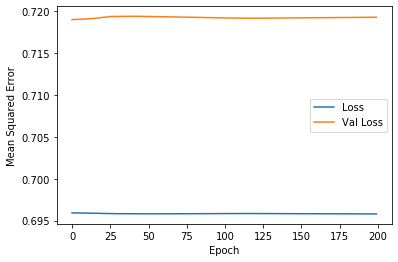

,k6a1_test,k6a2_test,k11_test,k12_test,k9a1_test,k9a2_test,k6a1_hat,k6a2_hat,k11_hat,k12_hat,k9a1_hat,k9a2_hat
0,1.0,-1.0,1.0,0.0,-1.0,-1.0,0.173475,0.168639,0.163112,0.161114,0.162344,0.171314
1,1.0,-1.0,0.0,-1.0,-1.0,1.0,0.173475,0.168642,0.163112,0.161114,0.162346,0.171312
2,1.0,-1.0,0.0,-1.0,0.0,1.0,0.173475,0.168642,0.163111,0.161115,0.162345,0.171312
3,-1.0,1.0,1.0,0.0,0.0,-1.0,0.173476,0.168639,0.163113,0.161114,0.162345,0.171314
4,0.0,0.0,1.0,1.0,0.0,-1.0,0.173475,0.168639,0.163113,0.161114,0.162345,0.171314
5,1.0,-1.0,0.0,0.0,1.0,0.0,0.173475,0.168640,0.163112,0.161116,0.162345,0.171313
6,-1.0,-1.0,-1.0,0.0,-1.0,1.0,0.173476,0.168639,0.163113,0.161114,0.162345,0.171314
7,-1.0,0.0,-1.0,1.0,1.0,-1.0,0.173475,0.168638,0.163113,0.161114,0.162345,0.171314
8,-1.0,-1.0,1.0,0.0,0.0,0.0,0.173476,0.168641,0.163112,0.161114,0.162344,0.171314
9,1.0,0.0,1.0,-1.0,-1.0,0.0,0.173476,0.168637,0.163114,0.161112,0.162346,0.171315


In [341]:
#features = {name:np.array(value) for name, value in df_test.items()}
#label=df_test[label_name].to_numpy()
#data_train, data_test, labels_train, labels_test
plot_the_loss_curve(epochs, mse,val_mse)
#evaluation=two_d_model.evaluate(x = data_test, y = labels_test)

#print("Hello",data_test[:3])
predicted = two_d_model.predict(data_test)
#predicted=predicted.reshape(len(data_test),6,2)
#print(predicted)


#decode labels:
#print(predicted)



df_test=pd.DataFrame(labels_test,columns=["k6a1_test","k6a2_test","k11_test","k12_test","k9a1_test","k9a2_test"])
df_predict=pd.DataFrame(predicted,columns=["k6a1_hat","k6a2_hat","k11_hat","k12_hat","k9a1_hat","k9a2_hat"])
pd.concat([df_test,df_predict], axis=1).head(20)